In [1]:
#MIkhail Senatorov

In [2]:
# Dataset contains

In [3]:
# PartB
#step1
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction import _stop_words
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import nltk
from nltk.stem import PorterStemmer
#Load dataset
train_df = pd.read_csv("climate_data/climate_train.csv", encoding="ISO-8859-1")
test_df = pd.read_csv("climate_data/climate_test.csv", encoding="ISO-8859-1")

In [4]:
#Step 2
#2.1
print(f"Data Shape: {train_df.shape}")
print(train_df["label"].value_counts() / train_df.shape[0])

Data Shape: (1000, 3)
label
0    0.575
1    0.425
Name: count, dtype: float64


In [5]:
#2.2 Keep only txt and label
train_df = train_df[["text", "label"]]
print(f"Cleaned Shape: {train_df.shape}")

Cleaned Shape: (1000, 2)


In [6]:
#2.3 Removing digits and stopwords
stopwords = _stop_words.ENGLISH_STOP_WORDS
def clean(doc):
 # Remove HTML line breaks
 doc = doc.replace("</br>", " ")
 # Remove punctuation and numbers
 doc = "".join([char for char in doc if char not in
string.punctuation and not char.isdigit()])
 # Remove stopwords and tokenize
 doc = " ".join([token for token in doc.split() if token not in stopwords])
 return doc


In [7]:
# TF-IDF Vectorizer with integrated preprocessor
tfidf_vect = TfidfVectorizer(preprocessor=clean)

# Fit on train Text (raw), transform both
X_train_tfidf = tfidf_vect.fit_transform(train_df['text'])
X_test_tfidf = tfidf_vect.transform(test_df['text'])

y_train = train_df['label']
y_test = test_df['label']  # Evaluation only

In [8]:
# Tran Multinominl Naive Bayes
nb = MultinomialNB()
%time nb.fit(X_train_tfidf, y_train)
# Make predictions
y_pred_class = nb.predict(X_test_tfidf)

CPU times: total: 0 ns
Wall time: 1.67 ms


Accuracy: 0.7875
Precision: 0.7027027027027027
Recall: 0.5306122448979592
F1 Score (macro): 0.7296760087457761
F1 Score (micro): 0.7875
ROC-AUC: 0.7157565728994302

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       222
           1       0.70      0.53      0.60        98

    accuracy                           0.79       320
   macro avg       0.76      0.72      0.73       320
weighted avg       0.78      0.79      0.78       320



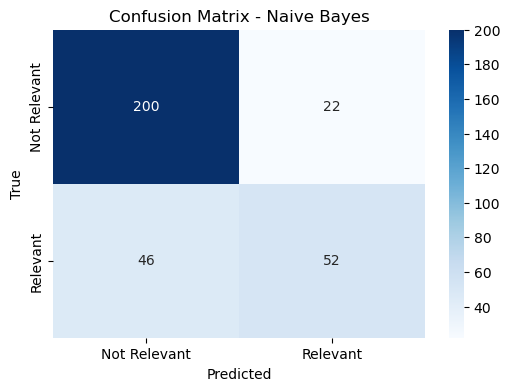

In [9]:
# Predictions
y_pred_nb = nb.predict(X_test_tfidf)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score (macro):", f1_score(y_test, y_pred_nb, average='macro'))
print("F1 Score (micro):", f1_score(y_test, y_pred_nb, average='micro'))  # For Part D
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix visualization (adapted from Lab 5)
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [10]:
# Feature names from vectorizer
feature_names = tfidf_vect.get_feature_names_out()

# Log probs (class 1 vs 0)
log_prob = nb.feature_log_prob_
diff = log_prob[1] - log_prob[0]  # Positive: more impactful for relevant (1)

# Top 10 for relevant
top_relevant_idx = diff.argsort()[-10:][::-1]
print("Top Impactful Tokens for Relevant (1):\n", [(feature_names[i], diff[i]) for i in top_relevant_idx])

# Top 10 for not relevant (negative diff)
top_not_idx = diff.argsort()[:10]
print("\nTop Impactful Tokens for Not Relevant (0):\n", [(feature_names[i], diff[i]) for i in top_not_idx])

Top Impactful Tokens for Relevant (1):
 [('million', np.float64(1.956946968246191)), ('committed', np.float64(1.7781464755051246)), ('solar', np.float64(1.7680346075407591)), ('green', np.float64(1.6848653435737262)), ('finance', np.float64(1.516666000419237)), ('IFC', np.float64(1.417803945003623)), ('billion', np.float64(1.4095102134673567)), ('target', np.float64(1.3781014252957933)), ('MW', np.float64(1.3190885566983743)), ('announced', np.float64(1.2931661909911591))]

Top Impactful Tokens for Not Relevant (0):
 [('physical', np.float64(-2.1452819560416447)), ('risks', np.float64(-2.080843390579737)), ('weather', np.float64(-2.0451839833962904)), ('events', np.float64(-1.904642120820534)), ('extreme', np.float64(-1.851581063724952)), ('changes', np.float64(-1.5483351673109347)), ('risk', np.float64(-1.487830239485012)), ('damage', np.float64(-1.469841001945401)), ('losses', np.float64(-1.4534283599896218)), ('costs', np.float64(-1.4151720023369974))]


In [11]:
# Logistic Regression
lr = LogisticRegression()
%time lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
print("\nLR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LR F1 (micro):", f1_score(y_test, y_pred_lr, average='micro'))

# Linear SVM
svm = LinearSVC()
%time svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM F1 (micro):", f1_score(y_test, y_pred_svm, average='micro'))

# KNN (n=5 default, after research: suitable for small datasets)
knn = KNeighborsClassifier(n_neighbors=5)
%time knn.fit(X_train_tfidf, y_train)
y_pred_knn = knn.predict(X_test_tfidf)
print("\nKNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN F1 (micro):", f1_score(y_test, y_pred_knn, average='micro'))

# Comparison table
models = ['NB', 'LR', 'SVM', 'KNN']
acc = [accuracy_score(y_test, pred) for pred in [y_pred_nb, y_pred_lr, y_pred_svm, y_pred_knn]]
f1_micro = [f1_score(y_test, pred, average='micro') for pred in [y_pred_nb, y_pred_lr, y_pred_svm, y_pred_knn]]
comp_df = pd.DataFrame({'Model': models, 'Accuracy': acc, 'F1 Micro': f1_micro})
print("\nClassifier Comparison:\n", comp_df)

# Conclusion: [After running: e.g., SVM often best for text due to margins; NB fastest. Depends on data imbalance.]

CPU times: total: 62.5 ms
Wall time: 6.03 ms

LR Accuracy: 0.78125
LR F1 (micro): 0.78125
CPU times: total: 0 ns
Wall time: 2.68 ms

SVM Accuracy: 0.76875
SVM F1 (micro): 0.76875
CPU times: total: 0 ns
Wall time: 495 μs

KNN Accuracy: 0.721875
KNN F1 (micro): 0.721875

Classifier Comparison:
   Model  Accuracy  F1 Micro
0    NB  0.787500  0.787500
1    LR  0.781250  0.781250
2   SVM  0.768750  0.768750
3   KNN  0.721875  0.721875


In [16]:
## 2. Feature Generation Comparison
#Best model from Part C.1 (assume LinearSVC; change if LR/KNN better).

# BoW comparison
from sklearn.feature_extraction.text import CountVectorizer

bow_vect = CountVectorizer(preprocessor=clean)
X_train_bow = bow_vect.fit_transform(train_df['text'])
X_test_bow = bow_vect.transform(test_df['text'])

best_model = LinearSVC()  
best_model.fit(X_train_bow, y_train)
y_pred_bow = best_model.predict(X_test_bow)

print("BoW F1 Micro:", f1_score(y_test, y_pred_bow, average='micro'))
print("BoW Accuracy:", accuracy_score(y_test, y_pred_bow))

BoW F1 Micro: 0.759375
BoW Accuracy: 0.759375


In [17]:
import time
start_time = time.time()

# Optimized TF-IDF (add max_features=5000 for speed/relevance)
tfidf_opt = TfidfVectorizer(preprocessor=clean, max_features=5000)
X_train_opt = tfidf_opt.fit_transform(train_df['text'])
X_test_opt = tfidf_opt.transform(test_df['text'])

# Best model (assume SVM; tune C=1.0 after tests)
opt_model = LinearSVC(C=1.0)
opt_model.fit(X_train_opt, y_train)
y_pred_opt = opt_model.predict(X_test_opt)

# Micro F1
micro_f1 = f1_score(y_test, y_pred_opt, average='micro')
print("Optimized Micro F1:", micro_f1)

end_time = time.time()
print("Runtime:", end_time - start_time, "seconds")

Optimized Micro F1: 0.775
Runtime: 0.09767985343933105 seconds
